# Natural Language Processing - First Steps

Data file with the reviews is here : https://drive.google.com/open?id=1xOAlHcKHr0Yk6A2uHunj2g-8uispDBsz

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
#nltk.download('stopwords')

In [45]:
review_df = pd.read_csv('review_split/review.part.00.csv', engine='python', error_bad_lines=False)

In [46]:
review_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,review_id,user_id,business_id,stars,date,text,useful,funny,cool
1,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
2,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
3,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
4,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0


In [47]:
review_df.drop([0], axis=0, inplace=True)

In [48]:
review_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296230 entries, 1 to 296230
Data columns (total 9 columns):
review_id      296230 non-null object
user_id        296230 non-null object
business_id    296230 non-null object
stars          296230 non-null object
date           296230 non-null object
text           296230 non-null object
useful         296230 non-null object
funny          296230 non-null object
cool           296230 non-null object
dtypes: object(9)
memory usage: 22.6+ MB


In [49]:
review_df.shape

(296230, 9)

In [50]:
review_df['text'][1]

"Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly."

In [51]:
review_df = review_df.drop(['business_id', 'date', 'review_id', 'user_id'], axis=1)
review_df = review_df.rename(columns={'stars':'Stars', 'text':'Text', 'cool':'Cool'
                                  , 'useful':'Useful', 'funny':'Funny'})
review_df.head()

,Stars,Text,Useful,Funny,Cool
1,5,Super simple place but amazing nonetheless. It...,0,0,0
2,5,Small unassuming place that changes their menu...,0,0,0
3,5,Lester's is located in a beautiful neighborhoo...,0,0,0
4,4,Love coming here. Yes the place always needs t...,0,0,0
5,4,Had their chocolate almond croissant and it wa...,0,0,0


In [52]:
review_df['Text Length'] = review_df['Text'].apply(len)
review_df.head()

,Stars,Text,Useful,Funny,Cool,Text Length
1,5,Super simple place but amazing nonetheless. It...,0,0,0,213
2,5,Small unassuming place that changes their menu...,0,0,0,502
3,5,Lester's is located in a beautiful neighborhoo...,0,0,0,373
4,4,Love coming here. Yes the place always needs t...,0,0,0,523
5,4,Had their chocolate almond croissant and it wa...,0,0,0,232


In [53]:
review_df[['Useful','Funny','Cool','Stars']] = review_df[['Useful','Funny','Cool','Stars']].apply(pd.to_numeric, errors='coerce', axis=1)

In [54]:
review_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296230 entries, 1 to 296230
Data columns (total 6 columns):
Stars          296230 non-null int64
Text           296230 non-null object
Useful         296230 non-null int64
Funny          296230 non-null int64
Cool           296230 non-null int64
Text Length    296230 non-null int64
dtypes: int64(5), object(1)
memory usage: 15.8+ MB


In [55]:
review_df.describe()

,Stars,Useful,Funny,Cool,Text Length
count,296230.000000,296230.000000,296230.000000,296230.000000,296230.000000
mean,3.741515,1.325480,0.461445,0.543092,617.334207
std,1.430526,5.316419,2.791416,2.854969,579.053304
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,243.000000
50%,4.000000,0.000000,0.000000,0.000000,437.000000
75%,5.000000,2.000000,0.000000,1.000000,788.000000
max,5.000000,1456.000000,589.000000,245.000000,9321.000000


In [56]:
yelp_text = review_df[['Stars', 'Text']]
yelp_text.head()

,Stars,Text
1,5,Super simple place but amazing nonetheless. It...
2,5,Small unassuming place that changes their menu...
3,5,Lester's is located in a beautiful neighborhoo...
4,4,Love coming here. Yes the place always needs t...
5,4,Had their chocolate almond croissant and it wa...


In [57]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation] # Creates a list where each element is a character
    remove_punc = ''.join(remove_punc) # Joins all list elements into one string
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')] # Creates a list 
    # by splitting all words based on space and test whwther the word belongs to stopwords (from english)

In [58]:
yelp_text_allstars = yelp_text.head(1000).copy()
yelp_text_allstars['Text'] = yelp_text_allstars['Text'].apply(remove_punc_stopword)
yelp_text_allstars.count()

Stars    1000
Text     1000
dtype: int64

In [59]:
yelp_text_allstars.head()

,Stars,Text
1,5,"[super, simple, place, amazing, nonetheless, a..."
2,5,"[small, unassuming, place, changes, menu, ever..."
3,5,"[lesters, located, beautiful, neighborhood, si..."
4,4,"[love, coming, yes, place, always, needs, floo..."
5,4,"[chocolate, almond, croissant, amazing, light,..."


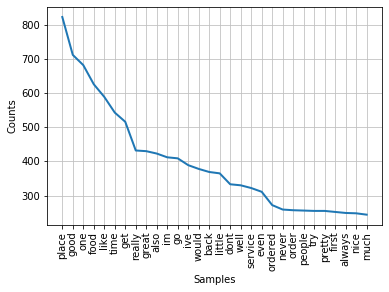

In [60]:
#30 most popular words if to take into account first reviews
words_split = []
for i in range(1,1001): 
    for word in yelp_text_allstars['Text'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

In [61]:
yelp_text_stars1 = yelp_text[yelp_text['Stars']==1].head(1000)
yelp_text_stars1['Text'] = yelp_text_stars1['Text'].apply(remove_punc_stopword)
yelp_text_stars1.count()

Stars    1000
Text     1000
dtype: int64

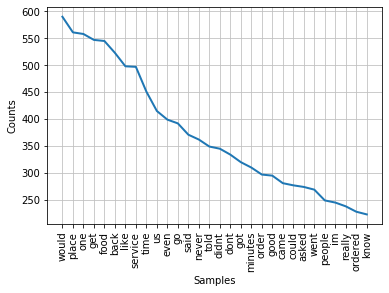

In [62]:
#30 most popular words in 1000 first reviews for business with stars = 1 (after we eliminate the punctuation and stop words)
yelp_text_stars1 = yelp_text_stars1.reset_index(drop=True)
words_split = []
for i in range(0,1000): 
    for word in yelp_text_stars1['Text'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

In [ ]:
yelp_text_stars5 = yelp_text[yelp_text['Stars']==5].head(1000)
yelp_text_stars5['Text'] = yelp_text_stars5['Text'].apply(remove_punc_stopword)
yelp_text_stars5.count()

In [ ]:
#30 most popular words in 1000 first reviews for business with stars = 5 (after we eliminate the punctuation and stop words)
yelp_text_stars5 = yelp_text_stars5.reset_index(drop=True)
words_split = []
for i in range(0,1000): 
    for word in yelp_text_stars5['Text'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)